In [16]:
!pip install boruta


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Task 1: Data Loading and Initial Exploration

   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St 

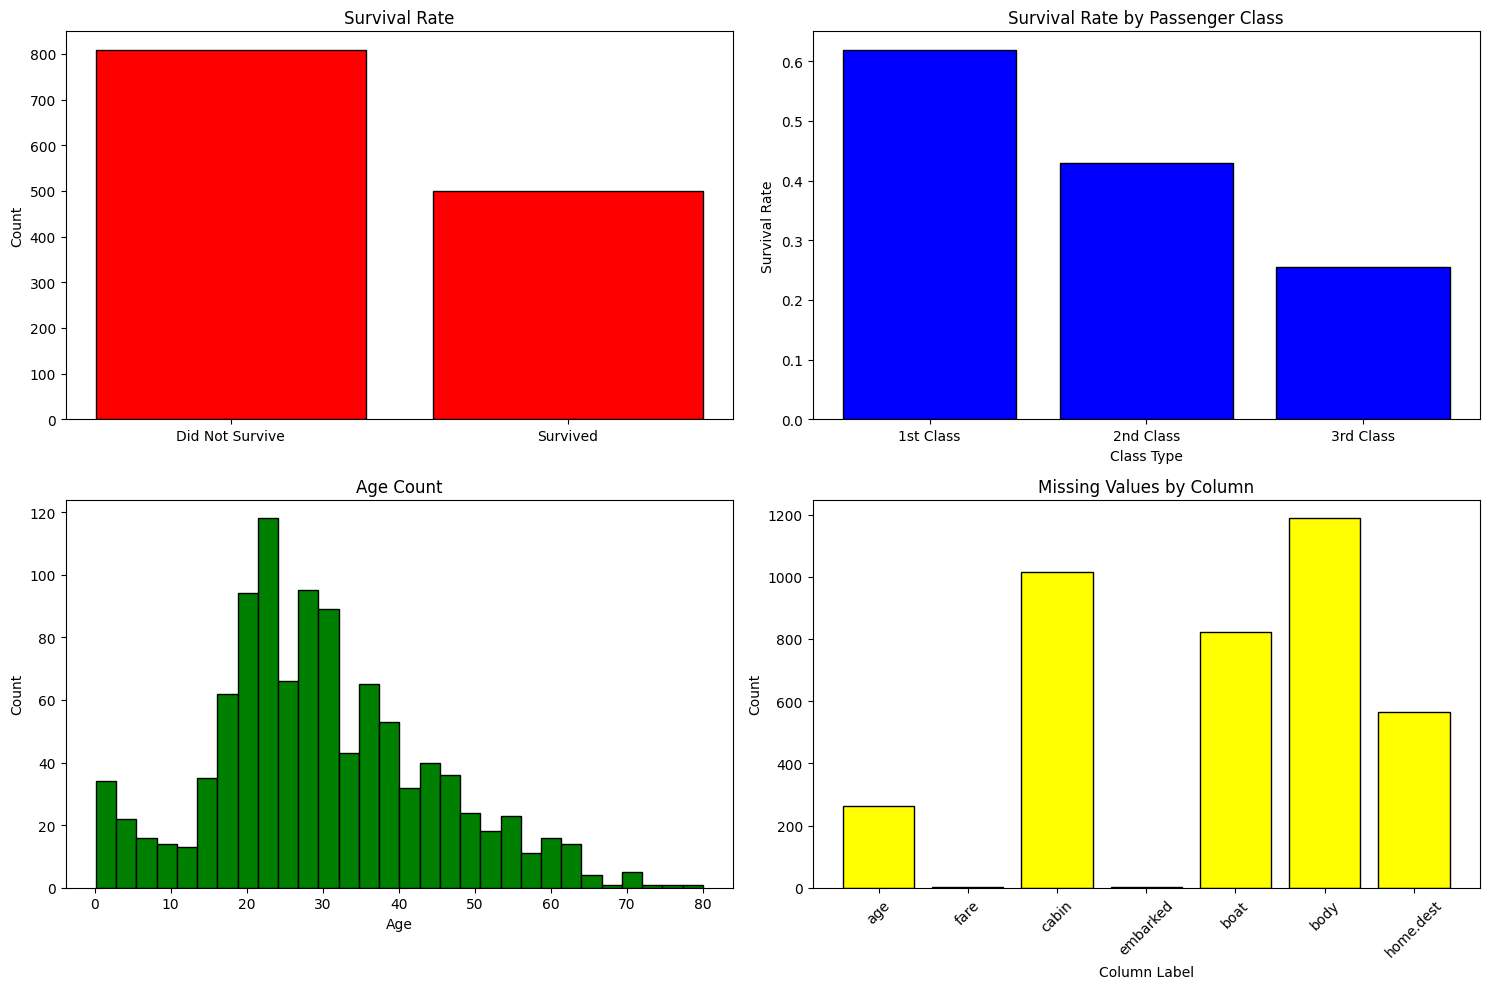

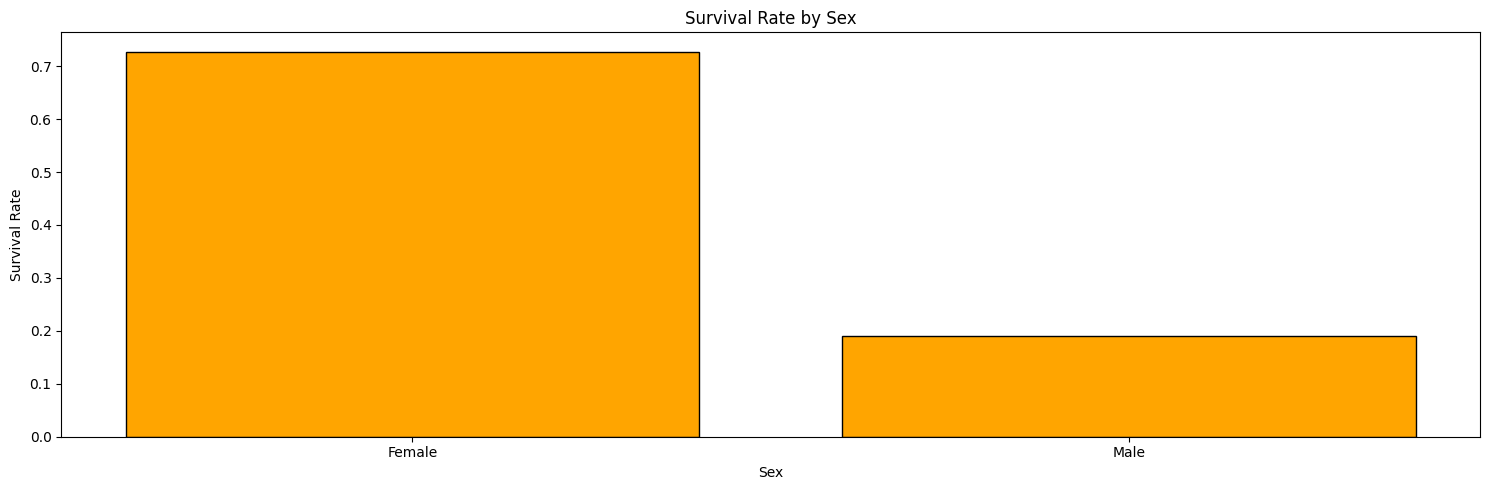

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Loading dataset into a data frame
import pandas as pd
df = pd.read_excel(r'C:\Users\Omar Issa\Desktop\titanic3.xls')

print(df.head())
print(df.info())


plt.figure(figsize=(15, 10))

# 1. Survival Distribution
plt.subplot(2, 2, 1)
survival_counts = df['survived'].value_counts()
plt.bar(['Did Not Survive', 'Survived'], [survival_counts[0], survival_counts[1]], color = 'red', edgecolor='black')
plt.title('Survival Rate')
plt.ylabel('Count')

# 2. Survival by Passenger Class
plt.subplot(2, 2, 2)
survival_by_class = df.groupby('pclass')['survived'].mean()
plt.bar(['1st Class', '2nd Class', '3rd Class'], survival_by_class, color = 'blue', edgecolor = 'black')
plt.title('Survival Rate by Passenger Class')
plt.ylabel('Survival Rate')
plt.xlabel('Class Type')

# 3. Age Distribution
plt.subplot(2, 2, 3)
plt.hist(df['age'].dropna(), bins=30, color = 'green', edgecolor='black')
plt.title('Age Count')
plt.xlabel('Age')
plt.ylabel('Count')

# 4. Missing Values
plt.subplot(2, 2, 4)
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
plt.bar(range(len(missing_values)), missing_values.values, color = 'yellow', edgecolor='black')
plt.xticks(range(len(missing_values)), missing_values.index, rotation=45)
plt.title('Missing Values by Column')
plt.ylabel('Count')
plt.xlabel('Column Label')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

# 5. Survival by Sex

survival_by_sex = df.groupby('sex')['survived'].mean()
plt.bar(['Female', 'Male'], survival_by_sex, color = 'orange', edgecolor='black')
plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rate')
plt.xlabel('Sex')

plt.tight_layout()
plt.show()


### *Task One Remarks: Reasoning behind plots:*

- Plot 1: Survival rate bar chart was used for me to understand who survived and who didn't.
- Plot 2: Passenger class survival rate could see the difference in survival rates per class, potentially indicating useful correlations.
- Plot 3: Age count histogram allowed me to the distribution of ages to understand if the passengers were young or old. This could aid in defining the 
  passenger's physical health in general.
- Plot 4: Missing values is important so I can gain insight into which columns need their data cleaned.
- Plot 5: The sex survival rate plot is important to show the disparity in how females vs males survived, as historically females were allowed to board
  the rescue boats before men. Hence, the disparity in survival rate.



## Task 2: Managing Missing Values

In [98]:
# Creating a copy of the data frame to avoid any issues
df_clean = df.copy()

# 1. Handle 'age':
# Strategy: Convert age to numeric values and fill missing age values with median age
median_age = df_clean['age'].median()
df_clean['age'] = df_clean['age'].fillna(median_age)

# 2. Handle 'cabin':
# Strategy: Create deck feature from first letter, then drop cabin
df_clean['deck'] = df_clean['cabin'].str[0]
df_clean['deck'] = df_clean['deck'].fillna('Unknown')

# 3. Handle 'fare':
# Strategy: Fill the missing value with the median
median_fares = df_clean.groupby('pclass')['fare'].median()
for pclass, median_fare in median_fares.items():
    mask = df_clean['pclass'] == pclass
    df_clean.loc[mask, 'fare'] = df_clean.loc[mask, 'fare'].fillna(median_fare)

# 4. Handling 'name':
# Strategy: Extract the title of the individuals and then drop the names.
df_clean['title'] = df_clean['name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Standardizing titles
title_mapping = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady': 'Mrs', 'Countess': 'Mrs', 'Dona': 'Mrs',
    'Sir': 'Mr', 'Don': 'Mr', 'Jonkheer': 'Mr',
    'Capt': 'Officer', 'Col': 'Officer', 'Major': 'Officer',
    'Dr': 'Officer', 'Rev': 'Officer'
}
df_clean['title'] = df_clean['title'].map(title_mapping).fillna(df_clean['title'])

# Dropping columns that aren't needed for prediction
columns_drop = ['ticket', 'cabin', 'boat', 'body', 'home.dest','name', 'embarked']
df_clean = df_clean.drop(columns=columns_drop)

print("\nColumns dropped after Task 2:")
print(columns_drop)
print("\nFinal columns after Task 2:")
print(df_clean.columns.tolist())



Columns dropped after Task 2:
['ticket', 'cabin', 'boat', 'body', 'home.dest', 'name', 'embarked']

Final columns after Task 2:
['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'deck', 'title']


## Task 3: Encoding Categorical Variables

In [99]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Categorical features identified after task 2
categorical_features = ['pclass', 'sex', 'deck', 'title']

# Create the encoder
encoder = OneHotEncoder(drop='first', sparse_output=False) # Drop first was used to prevent issues with multicollinearity
encoded_features = encoder.fit_transform(df_clean[categorical_features])

# Get feature names for encoded columns
feature_names = []
for i, feature in enumerate(categorical_features):
   categories = encoder.categories_[i][1:]  
   feature_names.extend([f"{feature}_{cat}" for cat in categories])

# Creating a DataFrame with encoded features
encoded_df = pd.DataFrame(encoded_features, columns=feature_names,index=df_clean.index)

print("\nColumns after encoding:")
print(encoded_df.columns.tolist())

df_encoded = pd.concat([df_clean.drop(columns=categorical_features), encoded_df], axis=1)


Columns after encoding:
['pclass_2', 'pclass_3', 'sex_male', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T', 'deck_Unknown', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_Officer']


## Task 4: Feature Scaling

In [100]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['age', 'fare', 'parch', 'sibsp']

# Creating copies for different scaling methods
df_standard = df_encoded.copy()
df_minmax = df_encoded.copy()

# StandardScaler for standardization of numerical features (mean=0, std=1)
scaler_standard = StandardScaler()
df_standard[numerical_features] = scaler_standard.fit_transform(df_standard[numerical_features])

# Displaying Results
print("\nSample of StandardScaler results:")
print(df_standard[numerical_features].head())


Sample of StandardScaler results:
        age      fare     parch     sibsp
0 -0.039005  3.442540 -0.445000 -0.479087
1 -2.215952  2.286641  1.866526  0.481288
2 -2.131977  2.286641  1.866526  0.481288
3  0.038512  2.286641  1.866526  0.481288
4 -0.349075  2.286641  1.866526  0.481288


## Task 5: Data Splitting

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separating features and target
X = df_encoded.drop('survived', axis=1)  # To avoid data leakage, survived was dropped
y = df_encoded['survived']               # Target (whether person survived or did not survive)

# Splitting into training (60%) and validation sets (40%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, stratify=y, random_state=8)

# Standardizing the data
numerical_features = ['age', 'fare', 'parch', 'sibsp']
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

# Transform validation data using the same scaler fitted on training data
X_val[numerical_features] = scaler.transform(X_val[numerical_features])

print("Training distribution:\n", y_train.value_counts(normalize=True))
print("Validation distribution:\n", y_val.value_counts(normalize=True))

Training distribution:
 survived
0    0.617834
1    0.382166
Name: proportion, dtype: float64
Validation distribution:
 survived
0    0.618321
1    0.381679
Name: proportion, dtype: float64


## Task 6: Addressing Class Imbalance

In [111]:
from imblearn.over_sampling import SMOTE

# Checking the imbalance
print("Imbalance in training data:")
print(y_train.value_counts())
print("\nTraining set shape before SMOTE:", X_train.shape) 

# Fixing the imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train) 

# Results after using SMOTE
print("\nTraining set shape after SMOTE:", X_resampled.shape)
print("\nClass distribution after SMOTE:")
print(y_resampled.value_counts())

Imbalance in training data:
survived
0    485
1    300
Name: count, dtype: int64

Training set shape before SMOTE: (785, 19)

Training set shape after SMOTE: (970, 19)

Class distribution after SMOTE:
survived
0    485
1    485
Name: count, dtype: int64


## Task 7: Feature Selection

Variances of features:
age: 1.0173
sibsp: 0.8683
parch: 0.9251
fare: 0.9852
pclass_2: 0.1809
pclass_3: 0.2499
sex_male: 0.2427
deck_B: 0.0550
deck_C: 0.0670
deck_D: 0.0371
deck_E: 0.0311
deck_F: 0.0160
deck_G: 0.0053
deck_T: 0.0000
deck_Unknown: 0.1826
title_Miss: 0.1744
title_Mr: 0.2495
title_Mrs: 0.1530
title_Officer: 0.0173

Features with variance > 0.01:
['age', 'sibsp', 'parch', 'fare', 'pclass_2', 'pclass_3', 'sex_male', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_Unknown', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_Officer']

Shape before variance threshold: (970, 19)

Shape after variance threshold: (970, 17)


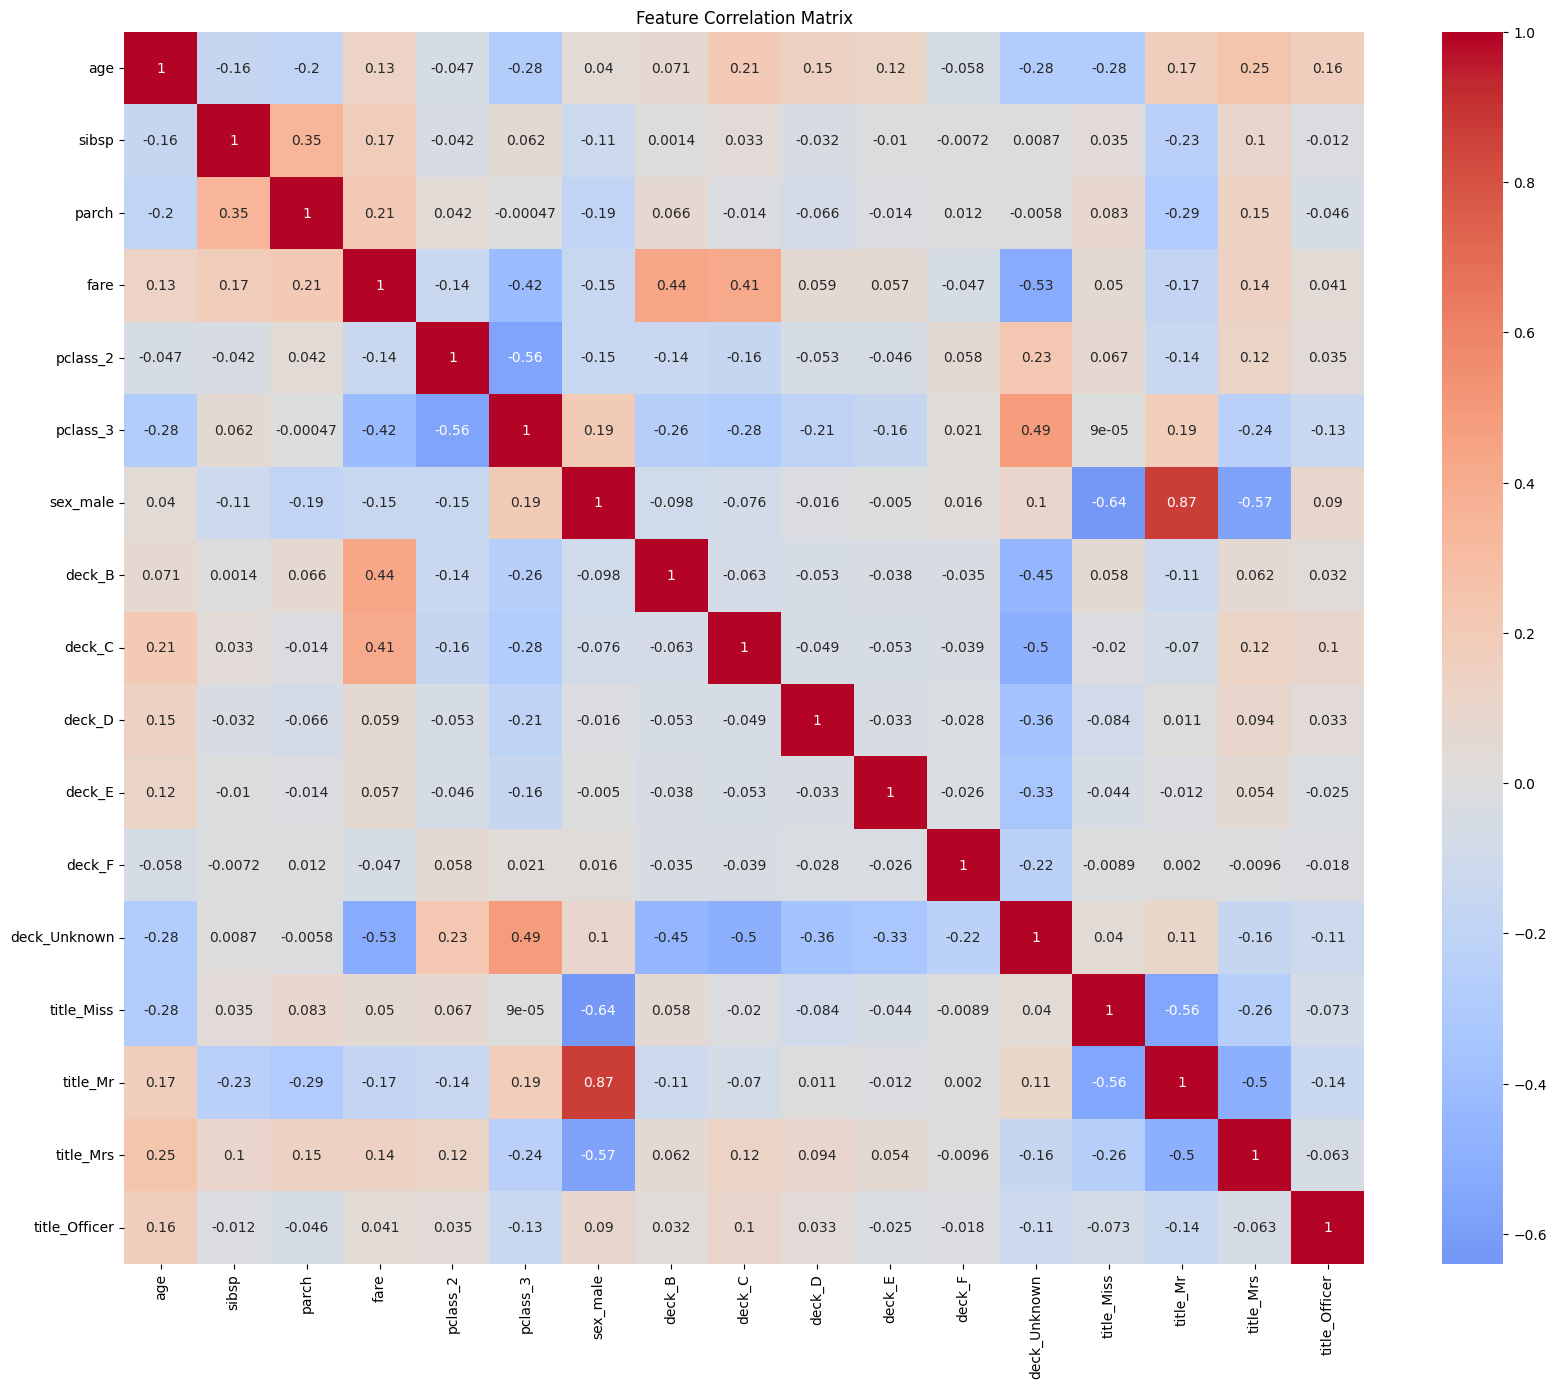

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	7

Features selected by Boruta:
['age', 'sibsp', 'parch', 'fare', 'pclass_3', 'sex_male', 'deck_Unknown', 'title_Miss', 'title_Mr', 'title_Mrs']

Feature Ranking:
   

In [112]:
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# First: Variance analysis
variances = X_resampled.var()
print("Variances of features:")
for feature, variance in variances.items():
    print(f"{feature}: {variance:.4f}")

# Applying variance threshold
threshold = 0.01
selector = VarianceThreshold(threshold)
X_selected = selector.fit_transform(X_resampled)

# Display results after low variance features were dropped
selected_features = X_resampled.columns[selector.get_support()].tolist()
print("\nFeatures with variance > 0.01:")
print(selected_features)
print("\nShape before variance threshold:", X_resampled.shape)
print("\nShape after variance threshold:", X_selected.shape)

# Second: Correlation analysis
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
corr = X_selected_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr, annot = True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Third: Boruta Feature Selection
rf = RandomForestClassifier(n_jobs=-1, max_depth=5)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2)
boruta.fit(X_selected, y_resampled)

# Getting selected feature names
selected_by_boruta = [selected_features[i] for i in range(len(selected_features)) if boruta.support_[i]]

print("\nFeatures selected by Boruta:")
print(selected_by_boruta)

# Showing ranking of features
feature_ranks = pd.DataFrame({'Feature': selected_features,'Rank': boruta.ranking_,'Important': boruta.support_})
print("\nFeature Ranking:")
print(feature_ranks.sort_values('Rank'))

X_selected_df = X_selected_df.drop('title_Mr', axis=1)
print("\nShape after dropping title_Mr:", X_selected_df.shape)


## *Task Seven Remarks*:

### 1) Variance analysis: 

- A low variance threshold was set at (0.01) which is what I found online is commonly used to determine low variance.

- 'deck_t' and 'deck_g' were removed for being below the variance threshold.

### 2) Correlation Matrix and Boruta algorithm analysis:

- The correlation matrix indicated generally a low correlation between multiple variables, this shows that most variables are independent.
- Boruta algorithm identified 10 key features which capture diverse aspects of passenger characteristics.
- The model indicates only one really strong correlation between the 'title_Mr'  and 'sex_male' at (0.87). This is expected, as the title 'Mr.' is used to indicate to a man. Hence, based on the boruta analysis and correlation matrix, to avoid redudancy of the data the 'title_Mr' was dropped.



## Task 8: Training a Logistic Regression Model

Overall Accuracy: 0.7729
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       324
           1       0.69      0.73      0.71       200

    accuracy                           0.77       524
   macro avg       0.76      0.76      0.76       524
weighted avg       0.78      0.77      0.77       524



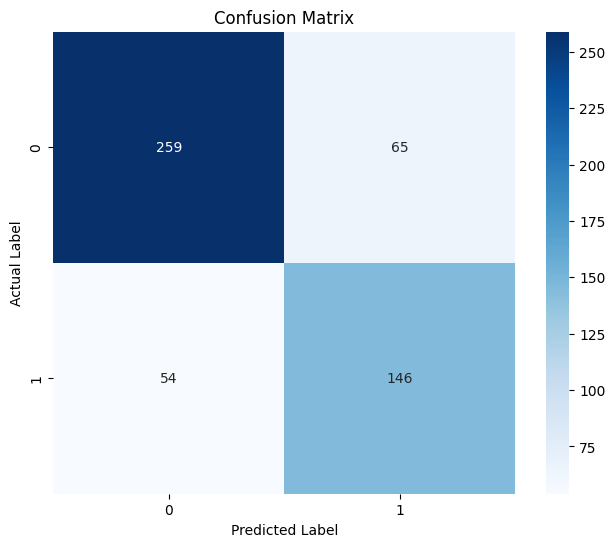

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Preparing data set after task seven results
X_val_selected = selector.transform(X_val)
X_val_df = pd.DataFrame(X_val_selected, columns=selected_features)
X_val_df = X_val_df.drop('title_Mr', axis=1)

# Training model
lr_model = LogisticRegression(random_state=8, max_iter=1000)
lr_model.fit(X_selected_df, y_resampled)
y_pred = lr_model.predict(X_val_df)

# Results
accuracy = accuracy_score(y_val, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred, zero_division=1))

# Displaying confusion matrix results on a seaborn plot to make it more visually appealing
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True,fmt='d', cmap='Blues', square=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()